In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from common import *
from PatientVec.Experiments.hyperparam_exps import *

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [4]:
import argparse
parser = argparse.ArgumentParser(description='Run Diagnosis experiments')
parser.add_argument("--data_dir", type=str, required=True)
parser.add_argument('--display', dest='display', action='store_true')
parser.add_argument("--output_dir", type=str)
parser.add_argument("--mock", dest='mock', action='store_true')

args = parser.parse_args(['--data_dir=.', '--output_dir=outputs/', '--display'])

In [ ]:
from dataloaders import readmission_dataset
data = readmission_dataset(args)

In [ ]:
train_data, dev_data = get_basic_data(data, structured=True, truncate=90)

In [ ]:
results_auc = {}
results_pr = {}

In [ ]:
results_auc_l1 = {}
results_pr_l1 = {}

In [ ]:
for l in [1, 2, 3] :
    config = {'vocab' : data.vocab, 'stop_words' : True, 'exp_name' : data.name, 
              'type' : data.metrics_type, 'norm' : 'l'+str(l), 'constant_mul' : 1.0}
    lr = LR(config)
    lr.train(train_data)
    metrics = lr.evaluate(dev_data, save_results=True)

In [ ]:
lr_models = {}
for c in [1.0, 2.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 10000, 100000] :
    config = {'vocab' : data.vocab, 'stop_words' : True, 'exp_name' : data.name, 
              'type' : data.metrics_type, 'norm' : 'l1', 'constant_mul' : c}
    lr = LR(config)
    lr.train(train_data)
    metrics = lr.evaluate(dev_data, save_results=True)
    results_auc_l1[c] = metrics['roc_auc']
    results_pr_l1[c] = metrics['pr_auc']

In [ ]:
logx = list(results_auc.keys())
plt.plot(logx, list(results_auc.values()))

In [ ]:
results_pr_l1

In [ ]:
results_auc

In [ ]:
l1_feat = lr_models[1].bow_classifier.estimators_[0].coef_[0]
l2_feat = lr_models[2].bow_classifier.estimators_[0].coef_[0]
l3_feat = lr_models[3].bow_classifier.estimators_[0].coef_[0]

In [ ]:
import seaborn as sns
sns.kdeplot(sorted(l1_feat))
sns.kdeplot(sorted(l2_feat))
sns.kdeplot(sorted(l3_feat))

In [ ]:
train_data = data.filter_data_length(data.get_data('train', structured=True), 90)

In [ ]:
args.data_dir = '../../../SurgeryData/PatientVec/'

In [5]:
from dataloaders import hip_dataset
data = hip_dataset(args)

INFO - 2019-03-19 15:01:40,567 - Reading Structured data ...
INFO - 2019-03-19 15:01:40,698 - Reading Notes ...
INFO - 2019-03-19 15:01:41,850 - Stratifying ...


In [6]:
from PatientVec.Experiments.evaluate import get_evaluator
train_data, dev_data = get_basic_data(data, structured=False, truncate=90)

Pos Percentage [0.10839746]


INFO - 2019-03-19 15:01:42,516 - Maximum Sentence Length 610378.000000 , 90 percentile length 32225.000000 ... 
INFO - 2019-03-19 15:01:43,715 - Truncated all ...
INFO - 2019-03-19 15:01:43,838 - Maximum Sentence Length 93892.000000 , 90 percentile length 27899.000000 ... 


Pos Percentage [0.08990536]


INFO - 2019-03-19 15:01:44,435 - Truncated all ...


In [26]:
evaluator = get_evaluator(data, 'Basic/LSTM(hs=128)+Replicate')
output = evaluator.evaluate(dev_data)

INFO - 2019-03-19 15:06:05,099 - instantiating class <class 'PatientVec.models.Model.Model'> from params {'type': 'seq_classifier', 'embedder': {'type': 'token_embedder', 'vocab_size': 24738, 'embed_size': 200, 'embedding_file': './preprocess/HipSurgery/3_yrs/embedding_matrix.npy'}, 'decoder': {'num_layers': 2, 'hidden_dims': [128, 1], 'activations': ['tanh', 'linear']}, 'predictor': {'type': 'binary', 'replicate': True, 'alpha': 0.3}, 'structured': {'use_structured': False}, 'encoder': {'type': 'lstm', 'hidden_size': 128}} and extras {}
INFO - 2019-03-19 15:06:05,099 - type = seq_classifier
INFO - 2019-03-19 15:06:05,099 - instantiating class <class 'PatientVec.models.modules.Embedder.Embedder'> from params {'type': 'token_embedder', 'vocab_size': 24738, 'embed_size': 200, 'embedding_file': './preprocess/HipSurgery/3_yrs/embedding_matrix.npy'} and extras {}
INFO - 2019-03-19 15:06:05,100 - embedder.type = token_embedder
INFO - 2019-03-19 15:06:05,100 - instantiating class <class 'Pati

Setting Embedding



{'accuracy': 0.750788643533123, 'roc_auc': 0.64967010246587, 'pr_auc': 0.16622182328777774}


,0.0,1.0,micro avg,macro avg,weighted avg
f1-score,0.850,0.275,0.751,0.562,0.798
precision,0.943,0.186,0.751,0.565,0.875
recall,0.773,0.526,0.751,0.650,0.751
support,577.000,57.000,634.000,634.000,634.000


In [27]:
config = {'vocab' : data.vocab, 'stop_words' : True, 'exp_name' : data.name, 
          'type' : data.metrics_type, 'norm' : 'l2', 'constant_mul' : 1.0}
lr = LR(config)
lr.train(train_data)
metrics = lr.evaluate(dev_data, save_results=True)
pred = lr.predict(dev_data)


Normalising using l2
Using Norm from linalg
Multiplying by constant ,  1.0
Fit BOW Classifier ...



Normalising using l2
Using Norm from linalg
Multiplying by constant ,  1.0
BOW
{'accuracy': 0.8580441640378549, 'roc_auc': 0.8024871537596158, 'pr_auc': 0.3785741830938421}


,0.0,1.0,micro avg,macro avg,weighted avg
f1-score,0.919,0.430,0.858,0.675,0.875
precision,0.957,0.337,0.858,0.647,0.901
recall,0.884,0.596,0.858,0.740,0.858
support,577.000,57.000,634.000,634.000,634.000



Normalising using l2
Using Norm from linalg
Multiplying by constant ,  1.0


In [28]:
lstm_y = output['predictions'][:, 0]
lr_y = pred[:, 1]
true_y = np.array(dev_data.y)[:, 0]

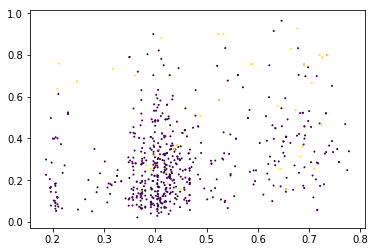

In [29]:
plt.scatter(lstm_y, lr_y, s=1, c=true_y)

In [30]:
from sklearn.metrics import *

In [31]:
bins = [0.0, 0.25, 0.5, 0.75]
results = {}
rocs = {}
for b in bins :
    idx = np.where(np.logical_and(lr_y >= b, lr_y < b+0.25))[0]
    results[b] = {'lr' : lr_y[idx], 'lstm' : lstm_y[idx], 'true' : true_y[idx]}
    rocs[b] = {'lr' : roc_auc_score(true_y[idx], lr_y[idx]), 'lstm' : roc_auc_score(true_y[idx], lstm_y[idx])}

In [32]:
rocs

{0.0: {'lr': 0.6882387706855791, 'lstm': 0.6462765957446809},
 0.25: {'lr': 0.39125386996904027, 'lstm': 0.5957172342621259},
 0.5: {'lr': 0.5872641509433962, 'lstm': 0.45754716981132076},
 0.75: {'lr': 0.5, 'lstm': 0.625}}

In [33]:
idx_end = np.where(np.logical_or(lr_y < 0.25, lr_y > 0.75))[0]
idx_middle = np.where(np.logical_and(lr_y > 0.25, lr_y < 0.75))[0]

In [37]:
roc_auc_score(true_y[idx_end], lr_y[idx_end]), roc_auc_score(true_y[idx_end], lstm_y[idx_end])

(0.8961852477477478, 0.7737894144144144)

In [36]:
roc_auc_score(true_y[idx_middle], lr_y[idx_middle]), roc_auc_score(true_y[idx_middle], lstm_y[idx_middle])

(0.6106438045939825, 0.5430281462309932)

Saving Models
==============

In [ ]:
from common import generate_latex_tables
keys_to_use = ['roc_auc', 'pr_auc']
generate_latex_tables(data, keys_to_use)

In [ ]:
dirname = 'outputs/Readmission/Basic/'
exps = os.listdir(dirname)
for e in sorted(exps) :
    if 'Structured' in e :
        print(e)
        print_results_from_model(get_latest_model(os.path.join(dirname, e)))

In [ ]:
dirname = 'outputs/Diagnosis/Basic/'
exps = os.listdir(dirname)
for e in sorted(exps) :
    if 'Structured' in e :
        print(e)
        print_results_from_model(get_latest_model(os.path.join(dirname, e)))